# Initialization

In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime, timedelta
import imageio
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd 'drive/MyDrive/GitHub/master-thesis'

/content/drive/MyDrive/GitHub/master-thesis


In [4]:
from clustering.utils import *

# Load Data

In [5]:
df_rvalue = pd.read_csv('data/inferred_rvalue.csv')
df_rvalue.date = pd.to_datetime(df_rvalue.date, format='%Y-%m-%d')
df_rvalue.head()

,date,R_t
0,2020-08-01,1.485275
1,2020-08-02,1.506616
2,2020-08-03,1.529095
3,2020-08-04,1.551009
4,2020-08-05,1.573704


In [6]:
factor_cols = get_factor_cols()

In [7]:
start_train = '2020-08-01'
df, cluster_input_cols, _, _, _, _ = get_cluster_data(n_cluster=2, method='kmeans', cov_type='full', cluster_input_data='fa_data', start_train=start_train, end_train='2020-12-01', start='2020-07-14', end='2021-02-01')
df.head()

,F0_cautious_behaviour,F1_perception_advice,F2_applicability_usefullness_advice,F3_behaviour_others,F4_consequence_advice,gender,postnr,region,Q1_1_feel_exposed,Q1_2_covid_is_threat,...,Q16_Unsure_of_party_choice,Q16_Venstre,Vaccination_Status,Willingness_Vaccination,Q4_1_nr_contact_nonhouse_family,Q4_2_nr_contact_colleagues,Q4_3_nr_contact_friends,Q4_4_nr_contact_strangers,Q7_last_week_symptom,group
0,1.000000,0.819706,0.916667,0.250000,0.555556,1,4654,Zealand,3.0,7.0,...,0,0,NaN,NaN,0,0,2,2,0,0
1,0.875000,0.666667,0.291667,0.416667,0.611111,0,4700,Zealand,6.0,6.0,...,0,0,NaN,NaN,4,1,4,15,0,1
2,0.708333,0.083333,0.041667,0.666667,0.111111,0,4000,Zealand,2.0,5.0,...,1,0,NaN,NaN,4,0,0,1,0,1
3,1.000000,0.972222,0.750000,0.833333,0.611111,0,8543,Central,4.0,4.0,...,0,0,NaN,NaN,0,0,0,0,1,0
4,0.958333,0.916667,0.958333,1.000000,0.500000,1,3760,Capital,2.0,1.0,...,0,0,NaN,NaN,0,0,1,0,0,0


In [8]:
group_nr = 0
df_group = df.groupby(['date','group'],as_index=False)['gender'].count()
def normalize(row):
  sum = df_group[df_group['date']==row['date']]['gender'].sum()
  return row['gender']/sum
df_group['percentage'] = df_group.apply(lambda x: normalize(x), axis=1)
df_group.drop(columns='gender',inplace=True)
df_group = df_group[df_group['group'] == group_nr].reset_index(drop=True)
df_group = df_group.groupby('date').mean().rolling(7).mean().reset_index()
df_group = df_group.dropna().reset_index(drop=True)
df_group = df_group[df_group.date >= start_train]
df_group.head()

,date,group,percentage
12,2020-08-01,0.0,0.576811
13,2020-08-02,0.0,0.583078
14,2020-08-03,0.0,0.582858
15,2020-08-04,0.0,0.575050
16,2020-08-05,0.0,0.573277


In [9]:
"""
df_alternativ = pd.read_csv('data/clustering/220309_percentage_non_careful.csv')
df_alternativ.date = pd.to_datetime(df_alternativ.date, format='%Y-%m-%d')
df_group = df_alternativ
df_group = df_group.groupby('date').mean().rolling(7).mean().reset_index()
df_group = df_group[(df_group.date >= start_train) & (df_group.date < '2021-02-01')]
df_group.info()"""

"\ndf_alternativ = pd.read_csv('data/clustering/220309_percentage_non_careful.csv')\ndf_alternativ.date = pd.to_datetime(df_alternativ.date, format='%Y-%m-%d')\ndf_group = df_alternativ\ndf_group = df_group.groupby('date').mean().rolling(7).mean().reset_index()\ndf_group = df_group[(df_group.date >= start_train) & (df_group.date < '2021-02-01')]\ndf_group.info()"

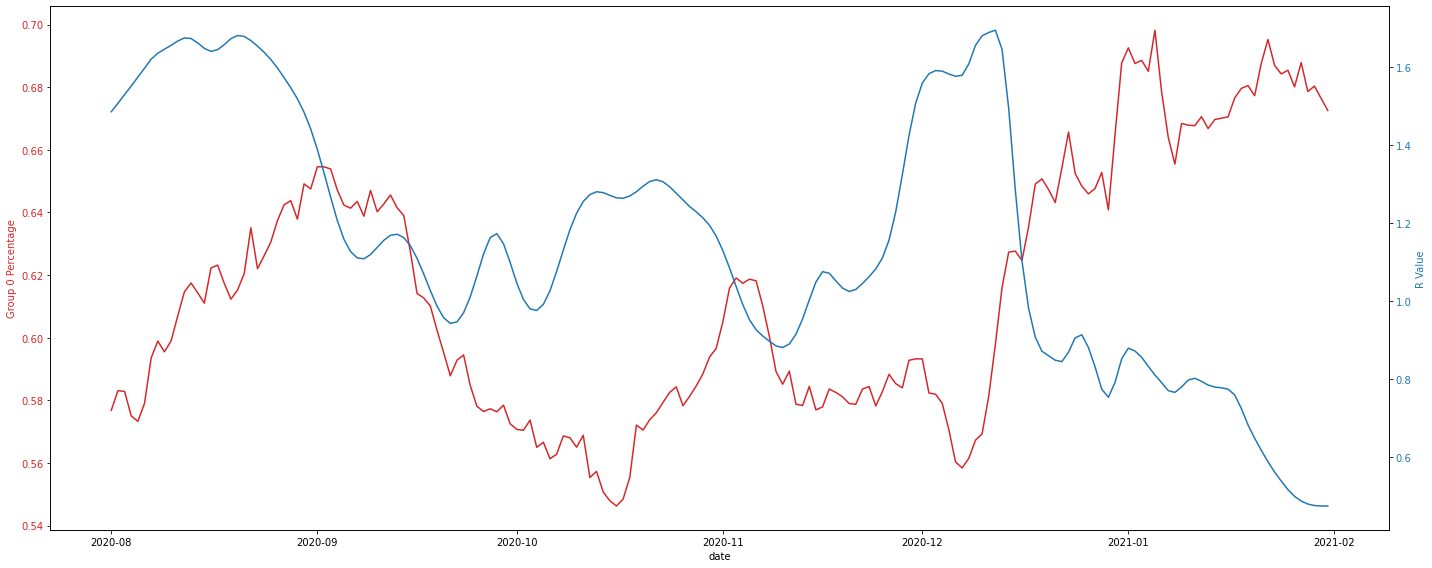

In [10]:
fig, ax1 = plt.subplots(figsize=(20, 8))
#df_group['percentage_transformed'] = df_group['percentage'].diff().rolling(7).mean()
color = 'tab:red'
ax1.set_xlabel('date')
ax1_ylabel = 'Group ' + str(group_nr) + ' Percentage'
ax1.set_ylabel(ax1_ylabel, color=color)
ax1.plot(df_group['date'], df_group['percentage'], color=color)
#ax1.plot(df_group['date'], df_group['percentage_transformed'], color='grey')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('R Value', color=color)  # we already handled the x-label with ax1
ax2.plot(df_rvalue['date'], df_rvalue['R_t'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Comparison Factor Values and R Value

In [11]:
df_factor = df.groupby('date').mean().rolling(7).mean()[factor_cols].reset_index()
df_factor = df_factor[df_factor.date >= start_train]
df_factor

,date,F0_cautious_behaviour,F1_perception_advice,F2_applicability_usefullness_advice,F3_behaviour_others,F4_consequence_advice
18,2020-08-01,0.743703,0.731844,0.788875,0.524872,0.434281
19,2020-08-02,0.746341,0.732994,0.791286,0.533191,0.435649
20,2020-08-03,0.744210,0.731432,0.791726,0.531481,0.435569
21,2020-08-04,0.746002,0.727886,0.791847,0.528625,0.439712
22,2020-08-05,0.749690,0.725442,0.793338,0.527307,0.435948
...,...,...,...,...,...,...
197,2021-01-27,0.856608,0.740694,0.799087,0.670694,0.614807
198,2021-01-28,0.851948,0.734714,0.803258,0.669949,0.619640
199,2021-01-29,0.853168,0.735961,0.803334,0.668453,0.617294
200,2021-01-30,0.848604,0.730046,0.804182,0.666618,0.614588


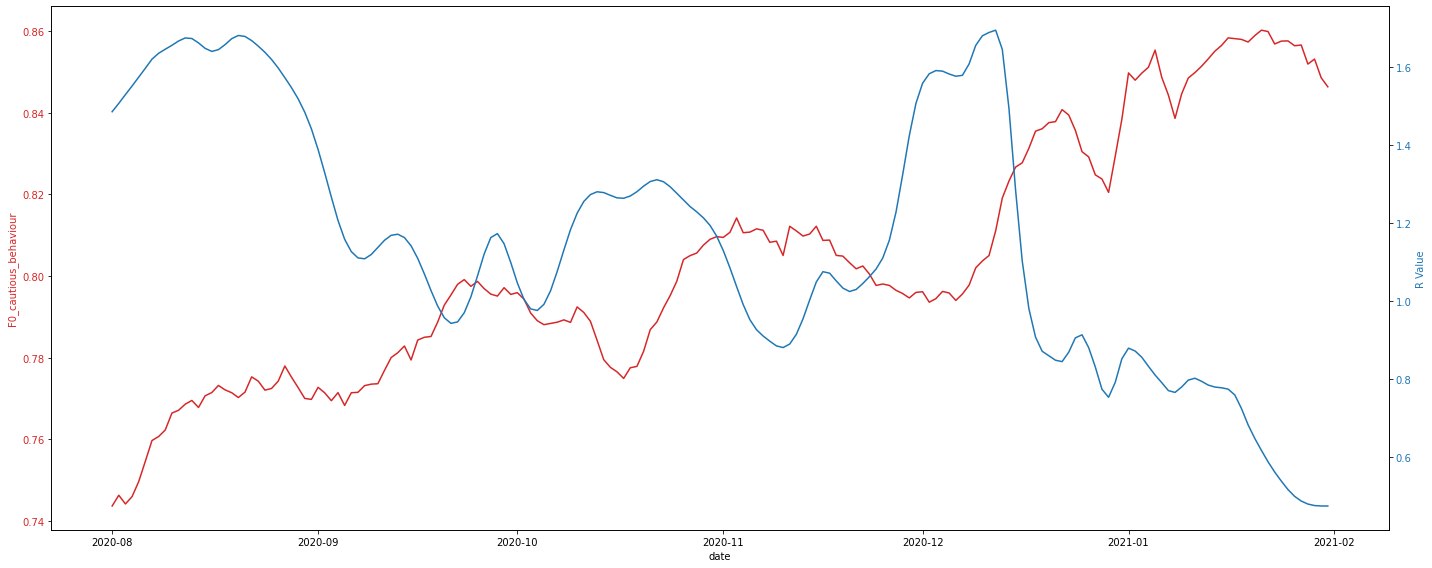

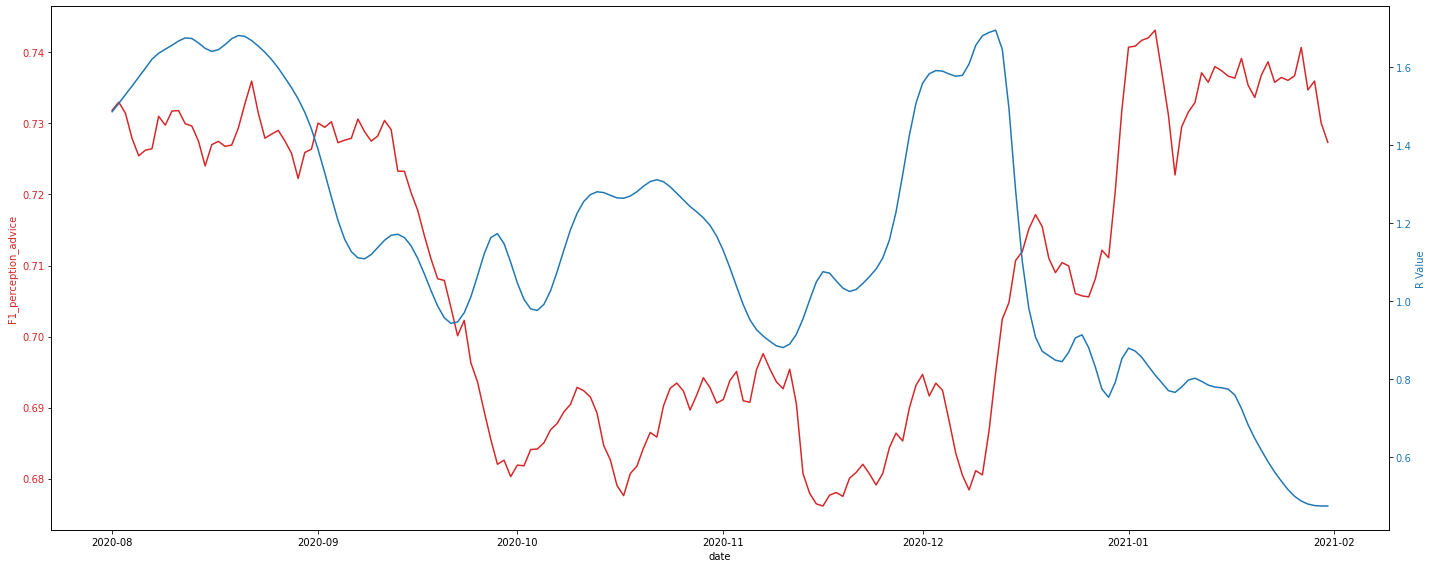

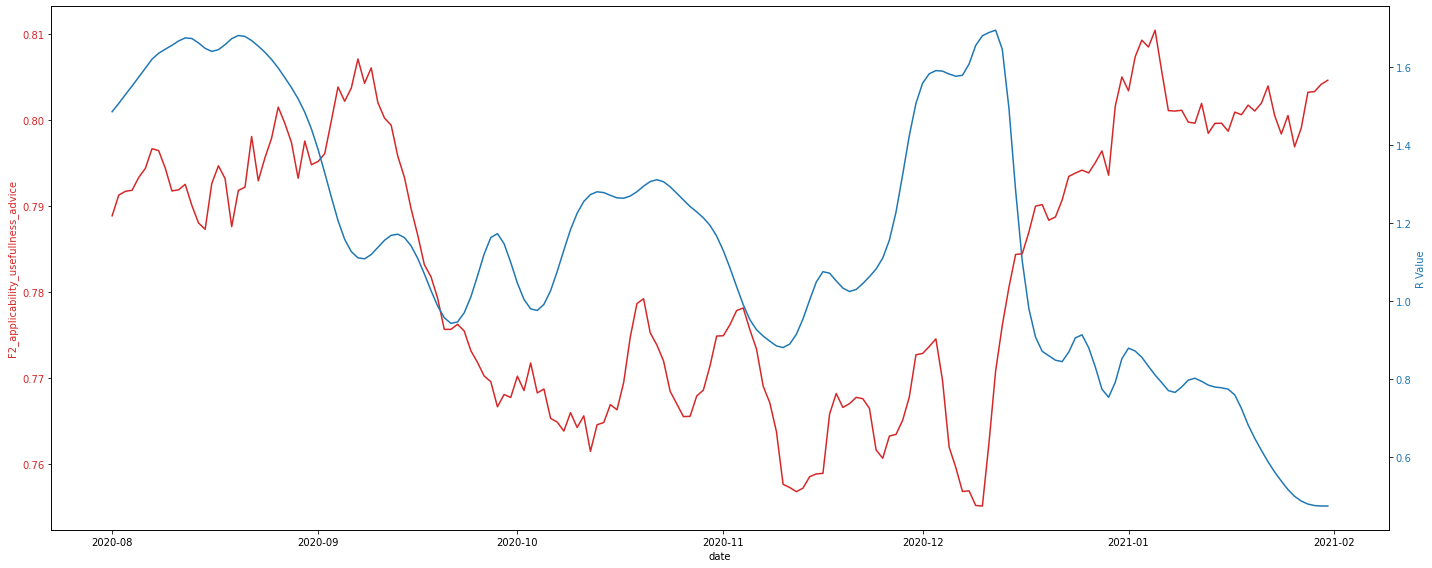

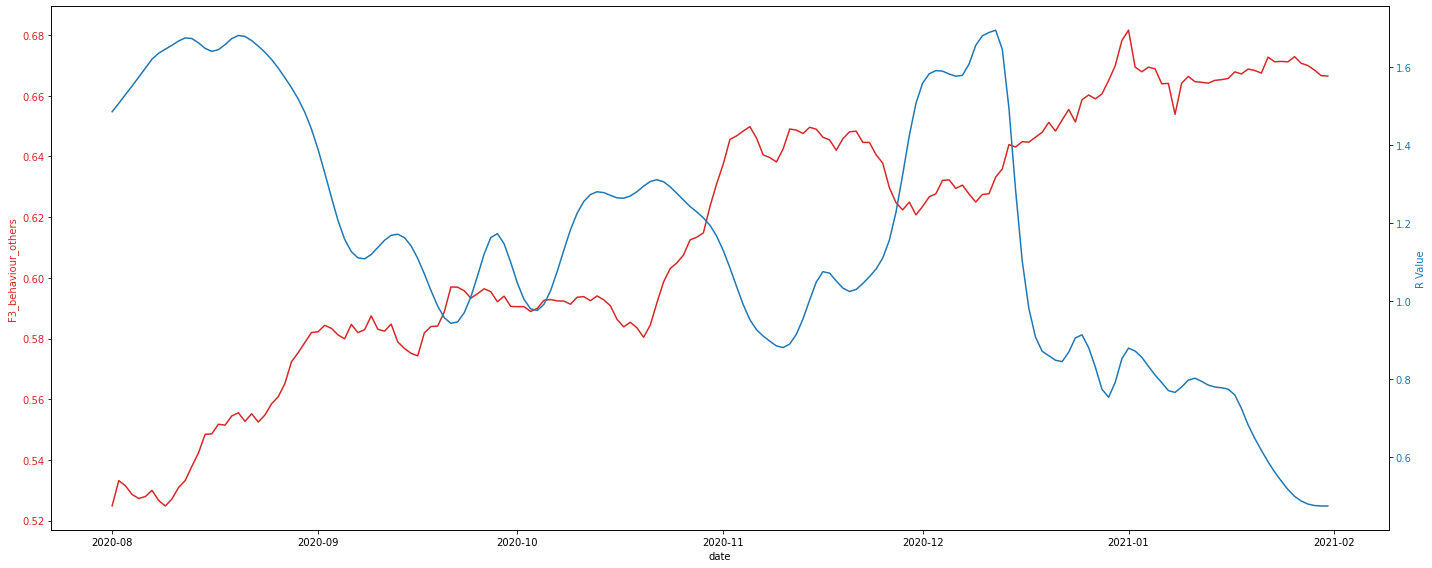

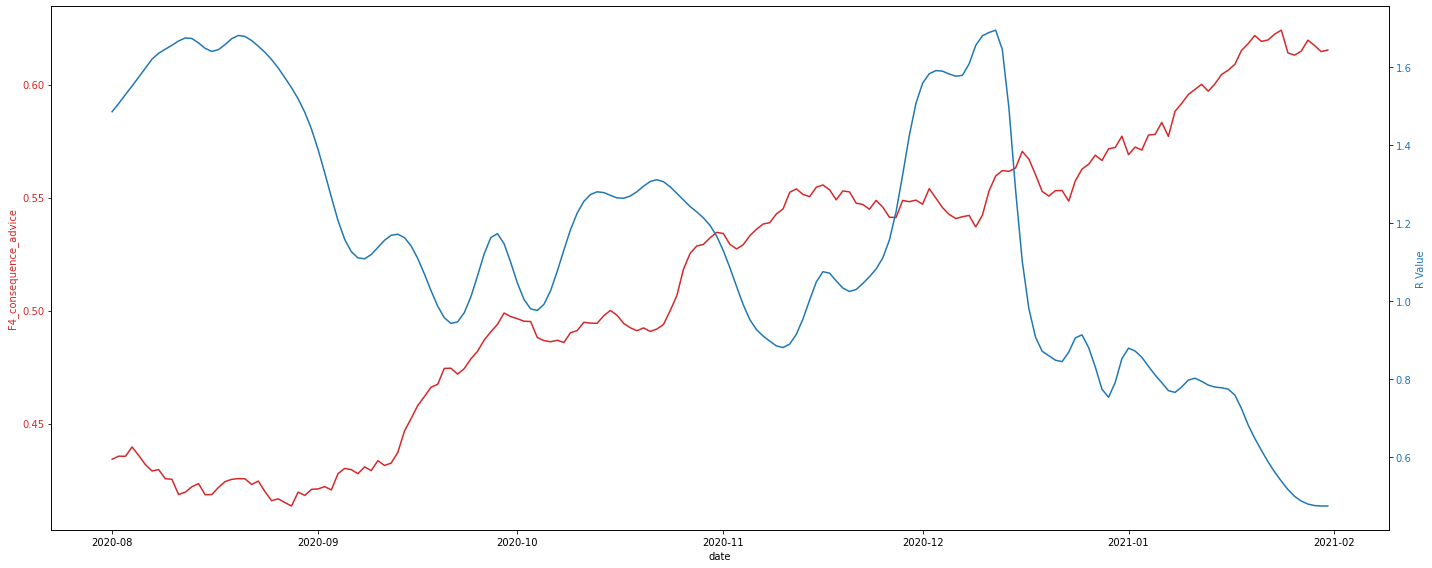

In [12]:
for column in factor_cols:

  fig, ax1 = plt.subplots(figsize=(20, 8))
  color = 'tab:red'
  ax1.set_xlabel('date')
  ax1_ylabel = column
  ax1.set_ylabel(ax1_ylabel, color=color)
  ax1.plot(df_factor['date'], df_factor[column], color=color)
  ax1.tick_params(axis='y', labelcolor=color)

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

  color = 'tab:blue'
  ax2.set_ylabel('R Value', color=color)  # we already handled the x-label with ax1
  ax2.plot(df_rvalue['date'], df_rvalue['R_t'], color=color)
  ax2.tick_params(axis='y', labelcolor=color)

  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  plt.show()